In [1]:
import sys
sys.path.append('/home/jianming/PONet/program/project/FactorVAE')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import argparse
import os
import random
from accelerate import Accelerator

In [3]:
num_epochs = 25
lr = 0.0001
batch_size = 1024
batch_gap = 1
num_latent = 6 # feature size
seq_len = 60
num_factor = 32
hidden_size = 32
hidden_factor = 32
seed = 42
save_dir = r'/home/jianming/PONet/program/project/FactorVAE/data/best_models'

In [4]:
# train_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/train_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
# valid_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/valid_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
# test_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/test_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
# US_feature_dataset_market_sp500_valid_start2015-01-01_end2016-12-31_label5
train_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/US_feature_dataset_market_sp500_train_start2008-01-01_end2014-12-31_label20")
valid_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/US_feature_dataset_market_sp500_valid_start2015-01-01_end2016-12-31_label20")
test_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/US_feature_dataset_market_sp500_test_start2017-01-01_end2020-08-01_label20")

In [69]:
train_df['feature']

CLOSE59   CLOSE58   CLOSE57   CLOSE56   CLOSE55  \
datetime   instrument                                                     
2010-01-04 A          -0.801470 -0.792347 -0.805499 -0.865277 -0.789545   
           AA         -0.939941 -1.010894 -1.017612 -1.105897 -1.004793   
           AAPL       -0.721489 -0.681588 -0.676562 -0.719535 -0.676018   
           ABC        -1.130259 -1.073238 -1.041954 -1.094959 -0.954652   
           ABT        -0.469372 -0.482687 -0.503474 -0.503206 -0.250961   
...                         ...       ...       ...       ...       ...   
2017-12-29 XYL        -0.202851 -0.197502 -0.190815 -0.199200 -0.248474   
           YUM        -0.490197 -0.351213 -0.350005 -0.336936 -0.292932   
           ZBH         0.177233  0.181779  0.049109  0.112167  0.126088   
           ZION       -0.277664 -0.246040 -0.347252 -0.288158 -0.372653   
           ZTS        -0.728868 -0.739231 -0.751547 -0.728709 -0.702852   

                        CLOSE54   CLOSE53   CLOSE52   CLOSE51   CLOSE50  ...  \
datetime   instrument                                                    ...   
2010-01-04 A          -0.792142 -0.926031 -0.881090 -1.176907 -1.066803  ...   
           AA         -0.995895 -1.188350 -1.186017 -1.361593 -1.361682  ...   
           AAPL       -0.718102 -0.838528 -0.770304 -0.387089 -0.119082  ...   
           ABC        -0.870498 -0.819805 -0.866395 -0.779866 -0.878006  ...   
           ABT        -0.137176 -0.225172 -0.092749 -0.163453 -0.294764  ...   
...                         ...       ...       ...       ...       ...  ...   
2017-12-29 XYL        -0.178195 -0.207453 -0.041043 -0.426306 -0.371775  ...   
           YUM        -0.326184 -0.357495 -0.363535 -0.374415 -0.402481  ...   
           ZBH         0.274740  0.200915  0.183904  0.213350  0.271014  ...   
           ZION       -0.482223 -0.512960 -0.486433 -0.645252 -0.622052  ...   
           ZTS        -0.632751 -0.574249 -0.548104 -0.545166 -0.588158  ...   

                        VOLUME9   VOLUME8   VOLUME7   VOLUME6   VOLUME5  \
datetime   instrument                                                     
2010-01-04 A           0.411700  0.298818 -0.209210 -0.420662 -1.603741   
           AA          0.294136  2.791438  0.451646  0.003445 -0.998537   
           AAPL        0.458316  0.476913 -0.632760 -0.662556  0.012183   
           ABC         2.104521  0.139758 -0.390253  0.114148 -1.781350   
           ABT         1.649119  0.253572 -0.155324 -1.024470 -1.570560   
...                         ...       ...       ...       ...       ...   
2017-12-29 XYL         1.498057  0.061790 -0.636312 -1.049967 -0.850350   
           YUM         3.000000  0.647190 -0.203018 -0.321770  0.491947   
           ZBH         2.270499  0.882518  3.000000  1.118766  0.122109   
           ZION        3.000000  2.210243  0.105724  0.725600  0.580410   
           ZTS         1.355472 -0.076837  0.280258  0.108470 -0.714964   

                        VOLUME4   VOLUME3   VOLUME2   VOLUME1  VOLUME0  
datetime   instrument                                                   
2010-01-04 A          -0.879167  0.303500  1.125745  1.020440      0.0  
           AA         -0.611950 -1.061957 -0.739595 -1.068296      0.0  
           AAPL        0.669912 -0.247133 -0.428418 -0.849569      0.0  
           ABC        -1.233891 -0.973650 -0.862436 -1.182416      0.0  
           ABT        -0.494855 -0.351178 -0.783187 -1.242245      0.0  
...                         ...       ...       ...       ...      ...  
2017-12-29 XYL        -1.539819 -1.857334 -1.269359 -1.614869      0.0  
           YUM        -0.728033 -1.193908 -0.561972 -1.460446      0.0  
           ZBH        -0.691201 -1.495628 -0.479991 -0.122525      0.0  
           ZION       -0.695005 -0.854849 -1.130369 -0.678290      0.0  
           ZTS        -0.487750 -1.263578 -0.808953 -1.696340      0.0  

[865331 rows x 360 columns]

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
class DataLoader:
    def __init__(
        self,
        df_feature,
        df_label,
        d_feat = 6,
        batch_size=1024,
        batch_gap = 20,
        shuffle=False,
        device=None,
    ):
        assert len(df_feature) == len(df_label)
        self.device = device

        self.df_feature = df_feature
        self.df_label = df_label

        self.batch_gap = batch_gap
        self.feature = torch.from_numpy(self.df_feature.values)
        self.label = torch.from_numpy(self.df_label.values)

        self.d_feat = d_feat
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __len__(self):
        return len(self.label) // (self.batch_size*self.batch_gap)

    def iter_batch(self):
        indices = np.arange(len(self.label))
        if self.shuffle:
            np.random.shuffle(indices)

        for i in range(len(indices))[:: (self.batch_size*self.batch_gap)]:
            if len(indices) - i < self.batch_size:
                break
            yield i, indices[i : i + self.batch_size]

    def get_batch(self, i, slc):
        outs = self.feature[slc].view(len(slc),self.d_feat, -1), self.label[slc]# No date in iter batch
        return outs

In [7]:
train_dataloader = DataLoader(train_df['feature'].fillna(0),train_df['label'].fillna(0), batch_gap = 20)
valid_dataloader = DataLoader(valid_df['feature'].fillna(0),valid_df['label'].fillna(0), batch_gap = 1)
test_dataloader = DataLoader(test_df['feature'].fillna(0),test_df['label'].fillna(0), batch_gap = 1)

In [8]:
len(train_dataloader)

42

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, num_latent, hidden_size, num_layers=1):
        super(FeatureExtractor, self).__init__()
        self.num_latent = num_latent
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.normalize = nn.LayerNorm(num_latent)
        self.linear = nn.Linear(num_latent, num_latent)
        self.leakyrelu = nn.LeakyReLU()
        self.gru = nn.GRU(num_latent, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        #! x: (batch_size, seq_length, num_latent)
        # Apply linear and LeakyReLU activation
        #* layer norm
        if x.shape[-1] != self.num_latent:
            x = x.permute((0,2,1))
        x = self.normalize(x)
        out = self.linear(x)
        out = self.leakyrelu(out)
        # Forward propagate GRU
        stock_latent, _ = self.gru(out)
        return stock_latent[:,-1,:] #* stock_latent[-1]: (batch_size, hidden_size)

class FactorEncoder(nn.Module):
    def __init__(self, num_factors, num_portfolio, hidden_size):
        super(FactorEncoder, self).__init__()
        self.num_factors = num_factors
        self.linear = nn.Linear(hidden_size, num_portfolio)
        self.softmax = nn.Softmax(dim=1)

        self.linear2 = nn.Linear(num_portfolio, num_factors)
        self.softplus = nn.Softplus()

    def mapping_layer(self, portfolio_return):
        #! portfolio_return: (batch_size, 1)
        #! mapping layer
        # print(portfolio_return.shape)
        mean = self.linear2(portfolio_return.squeeze(1))
        sigma = self.softplus(mean)
        return mean, sigma

    def forward(self, stock_latent, returns):
        #! stock_latent: (batch_size, hidden_size)
        #! returns: (batch_size, 1)
        #! make portfolio
        weights = self.linear(stock_latent)
        weights = self.softmax(weights) # (batch_size, num_portfolio)

        # multiply weights and returns
        #print(f"weights shape: {weights.shape}, returns shape: {returns.shape}") # [300, 20], [300, 1]
        # check returns.shape is tuple
        if returns.dim() == 1:
            returns = returns.unsqueeze(1)
        portfolio_return = torch.mm(weights.transpose(1,0), returns) #* portfolio_return: (M, 1)
        #print(f"portfolio_return shape: {portfolio_return.shape}")

        return self.mapping_layer(portfolio_return)

class AlphaLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AlphaLayer, self).__init__()
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.leakyrelu = nn.LeakyReLU()
        self.mu_layer = nn.Linear(hidden_size, 1)
        self.sigma_layer = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()

    def forward(self, stock_latent):
        #* stock latent는 FeatureExtractor에서 나온 것 (batch_size, hidden_size)
        stock_latent = self.linear1(stock_latent)
        stock_latent = self.leakyrelu(stock_latent)
        alpha_mu = self.mu_layer(stock_latent)
        alpha_sigma = self.sigma_layer(stock_latent)
        return alpha_mu, self.softplus(alpha_sigma)

class BetaLayer(nn.Module):
    """calcuate factor exposure beta(N*K)"""
    def __init__(self, hidden_size, num_factors):
        super(BetaLayer, self).__init__()
        self.linear1 = nn.Linear(hidden_size, num_factors)

    def forward(self, stock_latent):
        beta = self.linear1(stock_latent)
        return beta

class FactorDecoder(nn.Module):
    def __init__(self, alpha_layer, beta_layer):
        super(FactorDecoder, self).__init__()

        self.alpha_layer = alpha_layer
        self.beta_layer = beta_layer

    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def return_mu(self,stock_latent, factor_mu, factor_sigma):
        alpha_mu, alpha_sigma = self.alpha_layer(stock_latent)
        #print(f"alpha_mu shape: {alpha_mu.shape}, alpha_sigma shape: {alpha_sigma.shape}")
        beta = self.beta_layer(stock_latent)

        factor_mu = factor_mu.view(-1, 1)
        factor_sigma = factor_sigma.view(-1, 1)

        # Replace any zero values in factor_sigma with a small value
        factor_sigma[factor_sigma == 0] = 1e-6
        #print(f"factor_mu shape: {factor_mu.shape}, factor_sigma shape: {factor_sigma.shape}")
        #print(f"beta shape: {beta.shape}")
        mu = alpha_mu + torch.matmul(beta, factor_mu)
        return mu

    def forward(self, stock_latent, factor_mu, factor_sigma):
        #! warning: alpha_mu, alpha_sigma -> (N), (N)
        alpha_mu, alpha_sigma = self.alpha_layer(stock_latent)
        #print(f"alpha_mu shape: {alpha_mu.shape}, alpha_sigma shape: {alpha_sigma.shape}")
        beta = self.beta_layer(stock_latent)

        factor_mu = factor_mu.view(-1, 1)
        factor_sigma = factor_sigma.view(-1, 1)

        # Replace any zero values in factor_sigma with a small value
        factor_sigma[factor_sigma == 0] = 1e-6
        #print(f"factor_mu shape: {factor_mu.shape}, factor_sigma shape: {factor_sigma.shape}")
        #print(f"beta shape: {beta.shape}")
        mu = alpha_mu + torch.matmul(beta, factor_mu)
        sigma = torch.sqrt(alpha_sigma**2 + torch.matmul(beta**2, factor_sigma**2) + 1e-6)
        return self.reparameterize(mu, sigma)

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()

        self.query = nn.Parameter(torch.randn(hidden_size))
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, stock_latent):
        #* calculate attention weights

        self.key = self.key_layer(stock_latent)
        self.value = self.value_layer(stock_latent)

        attention_weights = torch.matmul(self.query, self.key.transpose(1,0)) # (N)
        #* scaling
        attention_weights = attention_weights / torch.sqrt(torch.tensor(self.key.shape[0])+ 1e-6)
        # print(f"attention_weights shape: {attention_weights.shape}")
        attention_weights = self.dropout(attention_weights)
        attention_weights = F.relu(attention_weights) # max(0, x)
        attention_weights = F.softmax(attention_weights, dim=0) # (N)

        #! calculate context vector
        if torch.isnan(attention_weights).any() or torch.isinf(attention_weights).any():
            return torch.zeros_like(self.value[0])
        else:
            context_vector = torch.matmul(attention_weights, self.value) # (H)
            return context_vector

class FactorPredictor(nn.Module):
    def __init__(self, batch_size, hidden_size, num_factor):
        super(FactorPredictor, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_factor = num_factor
        self.attention_layers = nn.ModuleList([AttentionLayer(self.hidden_size) for _ in range(num_factor)])

        self.linear = nn.Linear(hidden_size, hidden_size)
        self.leakyrelu = nn.LeakyReLU()
        self.mu_layer = nn.Linear(hidden_size, 1)
        self.sigma_layer = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()

    def forward(self, stock_latent):
        for i in range(self.num_factor):
            attention_layer = self.attention_layers[i](stock_latent)
            if i == 0:
                h_multi = attention_layer
            else:
                h_multi = torch.cat((h_multi, attention_layer), dim=0)
        h_multi = h_multi.view(self.num_factor, -1)

        # print("h_multi:", h_multi.shape)
        h_multi = self.linear(h_multi)
        h_multi = self.leakyrelu(h_multi)
        pred_mu = self.mu_layer(h_multi)
        pred_sigma = self.sigma_layer(h_multi)
        pred_sigma = self.softplus(pred_sigma)
        pred_mu = pred_mu.view(-1)
        pred_sigma = pred_sigma.view(-1)
        return pred_mu, pred_sigma

class FactorVAE(nn.Module):
    def __init__(self, feature_extractor, factor_encoder, factor_decoder, factor_predictor, risk_extrator, hidden_factor):
        super(FactorVAE, self).__init__()
        self.feature_extractor = feature_extractor
        self.factor_encoder = factor_encoder
        self.factor_decoder = factor_decoder
        self.factor_predictor = factor_predictor
        self.risk_extrator = risk_extrator
        self.hidden_factor = hidden_factor
        self.map = nn.Linear(64,hidden_factor)

    @staticmethod
    def KL_Divergence(mu1, sigma1, mu2, sigma2):
        #! mu1, mu2: (batch_size, 1)
        #! sigma1, sigma2: (batch_size, 1)
        #! output: (batch_size, 1)
        kl_div = (torch.log(sigma2/ sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5).sum()
        return kl_div

    def forward(self, x, returns):
        #! x: (batch_size, seq_length, num_latent)
        #! returns: (batch_size, 1)

        stock_latent = self.feature_extractor(x)
        risk_latent = self.risk_extrator(x)
        stock_latent = torch.cat([stock_latent,risk_latent],dim=1)
        stock_latent = self.map(stock_latent)
        # corr = torch.corrcoef(stock_latent.transpose(1,0))
        # U,_,_ = torch.pca_lowrank(corr, q=self.hidden_factor, center=True, niter=2)
        # stock_latent = torch.mm(stock_latent,U)/torch.sqrt(torch.Tensor(len(stock_latent)))

        factor_mu, factor_sigma = self.factor_encoder(stock_latent, returns)
        reconstruction = self.factor_decoder(stock_latent, factor_mu, factor_sigma)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)

        # print(f"pred_mu: {pred_mu.shape}, pred_sigma: {pred_sigma.shape}")
        # Define VAE loss function with reconstruction loss and KL divergence
        #* Some adjustment
        #* stock_adj: number of stocks that have no return data
        stock_adj = 0
        for i in range(len(returns)-1,-1,-1):
            if returns[i] == 0:
                stock_adj += 1
            else:
                break

        if stock_adj > 0:
            reconstruction_loss = F.mse_loss(reconstruction[:-stock_adj], returns[:-stock_adj])
        else:
            reconstruction_loss = F.mse_loss(reconstruction, returns)

        # Calculate KL divergence between two Gaussian distributions
        if torch.any(pred_sigma == 0):
            pred_sigma[pred_sigma == 0] = 1e-6
        kl_divergence = self.KL_Divergence(factor_mu, factor_sigma, pred_mu, pred_sigma)
        # regularization_loss = 0
        # prediction_loss = F.mse_loss(self.prediction(x),returns)
        vae_loss = reconstruction_loss + kl_divergence
        # print("loss: ", vae_loss)
        return vae_loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma #! reconstruction, factor_mu, factor_sigma

    # 학습 이후 사용
    def prediction(self, x):
        stock_latent = self.feature_extractor(x)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)
        y_pred = self.factor_decoder.return_mu(stock_latent, pred_mu, pred_sigma)
        return y_pred

    def latent_factor(self, x):
        stock_latent = self.feature_extractor(x)
        pred_mu, pred_sigma = self.factor_predictor(stock_latent)
        return (pred_mu, pred_sigma)

class GATModel(nn.Module):
    def __init__(self, d_feat=158, hidden_size=64, num_layers=2, dropout=0.0, base_model="GRU"):
        super().__init__()

        if base_model == "GRU":
            self.rnn = nn.GRU(
                input_size=d_feat,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
        elif base_model == "LSTM":
            self.rnn = nn.LSTM(
                input_size=d_feat,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
        else:
            raise ValueError("unknown base model name `%s`" % base_model)

        self.hidden_size = hidden_size
        self.d_feat = d_feat
        self.transformation = nn.Linear(self.hidden_size, self.hidden_size)
        self.a = nn.Parameter(torch.randn(self.hidden_size * 2, 1))
        self.a.requires_grad = True
        self.fc = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc_out = nn.Linear(hidden_size, hidden_size)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)

    def cal_attention(self, x, y):
        x = self.transformation(x)
        y = self.transformation(y)

        sample_num = x.shape[0]
        dim = x.shape[1]
        e_x = x.expand(sample_num, sample_num, dim)
        e_y = torch.transpose(e_x, 0, 1)
        attention_in = torch.cat((e_x, e_y), 2).view(-1, dim * 2)
        self.a_t = torch.t(self.a)
        attention_out = self.a_t.mm(torch.t(attention_in)).view(sample_num, sample_num)
        attention_out = self.leaky_relu(attention_out)
        att_weight = self.softmax(attention_out)
        return att_weight

    def forward(self, x):
        # x: [N, F*T]
        x = x.reshape(len(x), self.d_feat, -1)  # [N, F, T]
        x = x.permute(0, 2, 1)  # [N, T, F]
        out, _ = self.rnn(x)
        hidden = out[:, -1, :]
        att_weight = self.cal_attention(hidden, hidden)
        hidden = att_weight.mm(hidden) + hidden
        hidden = self.fc(hidden)
        hidden = self.leaky_relu(hidden)
        return self.fc_out(hidden).squeeze() # [N, hidden size]

class RiskFeatureExtractor(nn.Module):
    """supervise variance-covariance matrix reconstuction"""
    def __init__(self, num_latent, hidden_size,num_layers=2,dropout=0.2,base_model = 'GRU'):
        super(RiskFeatureExtractor, self).__init__()
        self.num_latent = num_latent
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.normalize = nn.LayerNorm(self.num_latent)
        self.linear = nn.Linear(self.num_latent, self.num_latent)
        self.leakyrelu = nn.LeakyReLU()
        self.GAT_model = GATModel(
            d_feat=self.num_latent,
            hidden_size=self.hidden_size,
            num_layers=num_layers ,
            dropout=dropout,
            base_model=base_model,
        )

    def forward(self, x):
        if x.shape[-1] != self.num_latent:
            x = x.permute((0,2,1))
        x = self.normalize(x)
        out = self.linear(x)
        out = self.leakyrelu(out)
        risk_latent = self.GAT_model(out)
        return risk_latent #* stock_latent[-1]: (batch_size, hidden_size)

In [10]:
set_seed(seed)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# create model
feature_extractor = FeatureExtractor(num_latent=num_latent, hidden_size=hidden_size)
risk_extrator = RiskFeatureExtractor(num_latent=num_latent, hidden_size = hidden_size)
factor_encoder = FactorEncoder(num_factors=num_factor, num_portfolio=num_factor, hidden_size=hidden_factor)
alpha_layer = AlphaLayer(hidden_factor)
beta_layer = BetaLayer(hidden_factor, num_factor)
factor_decoder = FactorDecoder(alpha_layer, beta_layer)
factor_predictor = FactorPredictor(batch_size, hidden_factor, num_factor)
factorVAE = FactorVAE(feature_extractor, factor_encoder, factor_decoder, factor_predictor, risk_extrator, hidden_factor)

In [11]:
def train(factor_model, dataloader, optimizer, batch_size, masked = False, benchmark = False):
    factor_model.to(device)
    factor_model.train()
    total_loss = 0
    reconstruction_loss = 0
    kl_loss = 0
    risk_loss = 0
    ic = 0
    mask_id = torch.randint(0, 500, (30,))
    pbar = tqdm(range(len(dataloader)), desc="Training", position=0,dynamic_ncols = True)
    for (i, slc),_ in zip(dataloader.iter_batch(),pbar):
        char, returns = dataloader.get_batch(i, slc)
        if char.size(0)!=batch_size:
            continue
        inputs = char
        labels = returns
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        if masked:
            inputs[mask_id,:,:] = 0

        if torch.isnan(inputs).any() or torch.isnan(labels).any():
            continue
        optimizer.zero_grad()
        if benchmark:
            pred = factor_model(inputs.view(batch_size,-1))
            reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = torch.nan,torch.nan,torch.nan,torch.nan, torch.nan
            loss = F.mse_loss(pred.unsqueeze(1),labels)
        else:
            loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = factor_model(inputs, labels)
            pred = factor_model.prediction(inputs)
        if loss>10:
            continue
        total_loss += loss.item() * inputs.size(0)
        # loss.backward()
        accelerator.backward(loss)
        optimizer.step()
        nn.utils.clip_grad_norm_(factor_model.parameters(), 1.0)
        try:
            reconstruction_loss += reconstruction.squeeze().mean().item()
            kl_loss += loss.item() + reconstruction.squeeze().mean().item()
        except:
            reconstruction_loss = 0
            kl_loss = 0
        # risk_loss += risk.squeeze().mean().item()
        # pred = factor_model.prediction(inputs)
        ic += np.corrcoef(pred.squeeze().detach().cpu().numpy().T,labels.squeeze().detach().cpu().numpy().T)[1,0]
        pbar.set_postfix({"Train Loss": loss.item()})

        # print(loss)
    ic = ic / len(dataloader)
    print('ic',ic)
    avg_loss = total_loss / len(dataloader)
    reconstruction_loss = reconstruction_loss/len(dataloader)
    kl_loss = kl_loss / len(dataloader)
    return avg_loss, reconstruction_loss, kl_loss, risk_loss


@torch.no_grad()
def validate(factor_model, dataloader, batch_size, benchmark = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    factor_model.to(device)
    factor_model.eval()
    total_loss = 0
    reconstruction_loss = 0
    ic = 0
    kl_loss = 0
    risk_loss = 0
    for i, slc in dataloader.iter_batch():
        char, returns = dataloader.get_batch(i, slc)
        if char.size(0)!=batch_size:
            continue
        inputs = char
        labels = returns[:,-1].reshape(-1,1)
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        if benchmark:
            pred = factor_model(inputs.view(batch_size,-1))
            reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = torch.nan,torch.nan,torch.nan,torch.nan, torch.nan
            loss = F.mse_loss(pred.unsqueeze(1),labels)
        else:
            loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = factor_model(inputs, labels)
            pred = factor_model.prediction(inputs)

        total_loss += loss.item() * inputs.size(0)

        try:
            reconstruction_loss += reconstruction.squeeze().mean().item()
            kl_loss += loss.item() + reconstruction.squeeze().mean().item()
        except:
            reconstruction_loss = 0
            kl_loss = 0

        # reconstruction_loss += reconstruction.squeeze().mean().item()
        # # risk_loss += risk.squeeze().mean().item()
        # kl_loss += loss.item() + reconstruction.squeeze().mean().item()
        ic += np.corrcoef(pred.squeeze().detach().cpu().numpy().T,labels.squeeze().detach().cpu().numpy().T)[1,0]
    ic = ic / len(dataloader)
    print('Test ic',ic)
    avg_loss = total_loss / len(dataloader)
    reconstruction_loss = reconstruction_loss/len(dataloader)
    kl_loss = kl_loss / len(dataloader)
    return avg_loss, reconstruction_loss, kl_loss, risk_loss

@torch.no_grad()
def test(factor_model, dataloader, seq_len):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    factor_model.to(device)
    factor_model.eval()
    total_loss = 0
    with tqdm(total=len(dataloader)-seq_len+1) as pbar:
        for char, returns,idx in dataloader:
            if char.shape[1] != seq_len:
                continue
            inputs = char.to(device)
            labels = returns.to(device)
            inputs = inputs.float()
            labels = labels.float()

            loss, reconstruction, factor_mu, factor_sigma, pred_mu, pred_sigma = factor_model(inputs, labels)
            total_loss += loss.item() * inputs.size(0)
            pbar.update(1)
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [32]:
class MLP(nn.Module):
    def __init__(self, d_feat, hidden_size=128, num_layers=3, dropout=0.0):
        super().__init__()

        self.mlp = nn.Sequential()
        for i in range(num_layers):
            if i > 0:
                self.mlp.add_module("drop_%d" % i, nn.Dropout(dropout))
            self.mlp.add_module("fc_%d" % i, nn.Linear(d_feat if i == 0 else hidden_size, hidden_size))
            self.mlp.add_module("bd_%d" % i, nn.BatchNorm1d(hidden_size))
            self.mlp.add_module("relu_%d" % i, nn.ReLU())

        self.mlp.add_module("fc_out", nn.Linear(hidden_size, 1))

    def forward(self, x):
        return self.mlp(x).squeeze()

In [33]:
model = MLP(d_feat = 360).cuda()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(factorVAE.parameters(), lr=0.001)
accelerator = Accelerator()
# model_name = '/home/jianming/PONet/program/project/FactorVAE/data/best_models/sp500model_with_riskmodel_period20_64.pt'
# factorVAE.load_state_dict(torch.load(model_name))
train_dataloader, factorVAE, optimizer = accelerator.prepare(train_dataloader, factorVAE, optimizer)
# optimizer = torch.optim.SGD(factorVAE.parameters(), lr=0.0001, momentum=0.9)

In [13]:
run_name = 'sp500model_with_riskmodel_periodm2002pic'
num_epochs = 15
train_loss_lst = []
valid_loss_lst = []
pbar = tqdm(range(num_epochs), desc="Training", position=0,dynamic_ncols = True)
torch.autograd.set_detect_anomaly(True)
for e in pbar:
    train_loss, train_conloss, train_kl, train_risk = train(factorVAE, train_dataloader, optimizer, batch_size, masked = False, benchmark= False)
    val_loss, val_conloss, val_kl, val_risk = validate(factorVAE, valid_dataloader, batch_size, benchmark = False)
    # val_loss, val_conloss, val_kl, val_risk = validate(factorVAE, test_dataloader, batch_size, benchmark = False)
    pbar.set_postfix({"Train Loss": train_loss, "Validation Loss": val_loss})
    save_root = os.path.join(save_dir, f'{run_name}_{num_factor}.pt')
    torch.save(factorVAE.state_dict(), save_root)
    train_loss_lst.append(train_loss)
    valid_loss_lst.append(val_loss)

Training:   0%|                                                                                               …

Training:   0%|                                                                                               …

ic 0.037219409354693936
Test ic 0.022824588839403897


Training:   0%|                                                                                               …

ic 0.025201832977490637
Test ic 0.022763590171739158


Training:   0%|                                                                                               …

ic 0.022317068125869404
Test ic 0.023146977733501564


Training:   0%|                                                                                               …

ic 0.024223523723187985
Test ic 0.024257286099280104


Training:   0%|                                                                                               …

ic 0.02610446303806612
Test ic 0.02489320112092215


Training:   0%|                                                                                               …

ic 0.026666621514207015
Test ic 0.024794412789843435


Training:   0%|                                                                                               …

ic 0.026918119574116214
Test ic 0.025384514170439125


Training:   0%|                                                                                               …

ic 0.02557126515113851
Test ic 0.024697939552424986


Training:   0%|                                                                                               …

ic 0.02559985503030583
Test ic 0.026025485483034374


Training:   0%|                                                                                               …

ic 0.025159696690139136
Test ic 0.025507740608200883


Training:   0%|                                                                                               …

ic 0.025293564919263496
Test ic 0.025997108465959297


Training:   0%|                                                                                               …

ic 0.02517946365710858
Test ic 0.025701172891001208


Training:   0%|                                                                                               …

ic 0.024410304412239132
Test ic 0.024853493479558827


Training:   0%|                                                                                               …

ic 0.022602604908651566
Test ic 0.026002666771202144


Training:   0%|                                                                                               …

ic 0.02373691905466734
Test ic 0.025563560152952178


In [ ]:
def list_to_df(loss_list):
    tcl = pd.DataFrame([i[0] for i in loss_list])
    vcl = pd.DataFrame([i[1] for i in loss_list])
    return tcl, vcl

In [14]:
tcl, vcl = pd.DataFrame(train_loss_lst), pd.DataFrame(valid_loss_lst)

In [15]:
tcl.to_csv('tcl.csv')
vcl.to_csv('vcl.csv')

<AxesSubplot:>

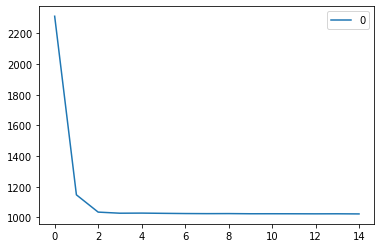

In [16]:
tcl.plot()

<AxesSubplot:>

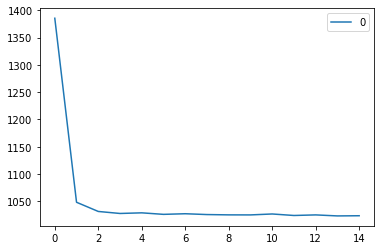

In [17]:
vcl.plot()

In [90]:
train_loss

0.0